# NB 07: Benchmarking Module-Based Predictions

Evaluate module-based function predictions against baselines:
1. **Cofitness voting**: top-N cofit partners → majority vote
2. **Ortholog transfer**: BBH annotation transfer
3. **Domain-only**: TIGRFam/PFam classification

**Two evaluation levels:**
- **Strict**: predict exact KEGG KO group → measure precision/coverage/F1
- **Neighborhood**: check if gene's true KO appears anywhere in the method's predicted functional neighborhood

Additional validation:
- Within-module cofitness density (per-module Mann-Whitney U test)
- Genomic adjacency (operon proximity enrichment)

**Run locally** — no Spark needed (uses extracted data).

**Note:** The full benchmark is implemented in `src/run_benchmark.py` for reproducibility.
Results are loaded from the saved output files below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

DATA_DIR = Path('../data')
MODULE_DIR = DATA_DIR / 'modules'
ANNOT_DIR = DATA_DIR / 'annotations'
ORTHO_DIR = DATA_DIR / 'orthologs'
PRED_DIR = DATA_DIR / 'predictions'
FIG_DIR = Path('../figures')

pilots = pd.read_csv(DATA_DIR / 'pilot_organisms.csv')
org_ids = pilots['orgId'].tolist()
print(f"{len(org_ids)} organisms")

32 organisms


## 1. Held-Out Benchmark Results

The benchmark was run via `src/run_benchmark.py` across all 32 organisms.
Each method predicts KEGG KO groups for 20% held-out annotated genes.

**Methods:**
- **Module-ICA**: assign the most common KO from the gene's module (train genes only)
- **Cofitness**: top-6 cofit partners → majority vote (vectorized correlation matrix)
- **Ortholog**: transfer KO from BBH ortholog in another organism
- **Domain**: TIGRFam/PFam → KO mapping from training genes

In [2]:
# Load precomputed benchmark results
results_df = pd.read_csv(PRED_DIR / 'benchmark_results.csv')

methods_order = ['Module-ICA', 'Cofitness', 'Ortholog', 'Domain']
colors = ['#2196F3', '#FF9800', '#4CAF50', '#9C27B0']

for level in ['strict', 'neighborhood']:
    level_df = results_df[results_df['eval_level'] == level]
    agg = level_df.groupby('method').agg(
        mean_precision=('precision', 'mean'),
        std_precision=('precision', 'std'),
        mean_coverage=('coverage', 'mean'),
        std_coverage=('coverage', 'std'),
        mean_f1=('f1', 'mean'),
        std_f1=('f1', 'std'),
        total_correct=('n_correct', 'sum'),
        total_predicted=('n_predicted', 'sum'),
    ).reindex(methods_order)
    
    print(f"\n{'='*60}")
    print(f"{level.upper()} evaluation (mean ± std across 32 organisms):")
    print(f"{'='*60}")
    for method in methods_order:
        row = agg.loc[method]
        print(f"  {method:12s}: prec={row['mean_precision']:.3f}±{row['std_precision']:.3f}  "
              f"cov={row['mean_coverage']:.3f}±{row['std_coverage']:.3f}  "
              f"F1={row['mean_f1']:.3f}±{row['std_f1']:.3f}")


STRICT evaluation (mean ± std across 32 organisms):
  Module-ICA  : prec=0.003±0.006  cov=0.233±0.058  F1=0.005±0.011
  Cofitness   : prec=0.002±0.004  cov=0.730±0.070  F1=0.003±0.007
  Ortholog    : prec=0.958±0.021  cov=0.912±0.058  F1=0.934±0.039
  Domain      : prec=0.291±0.066  cov=0.666±0.064  F1=0.401±0.073

NEIGHBORHOOD evaluation (mean ± std across 32 organisms):
  Module-ICA  : prec=0.032±0.022  cov=0.233±0.058  F1=0.053±0.031
  Cofitness   : prec=0.015±0.008  cov=0.730±0.070  F1=0.029±0.015
  Ortholog    : prec=0.992±0.010  cov=0.912±0.058  F1=0.949±0.036
  Domain      : prec=0.414±0.092  cov=0.666±0.064  F1=0.507±0.087


## 2. Benchmark Visualization

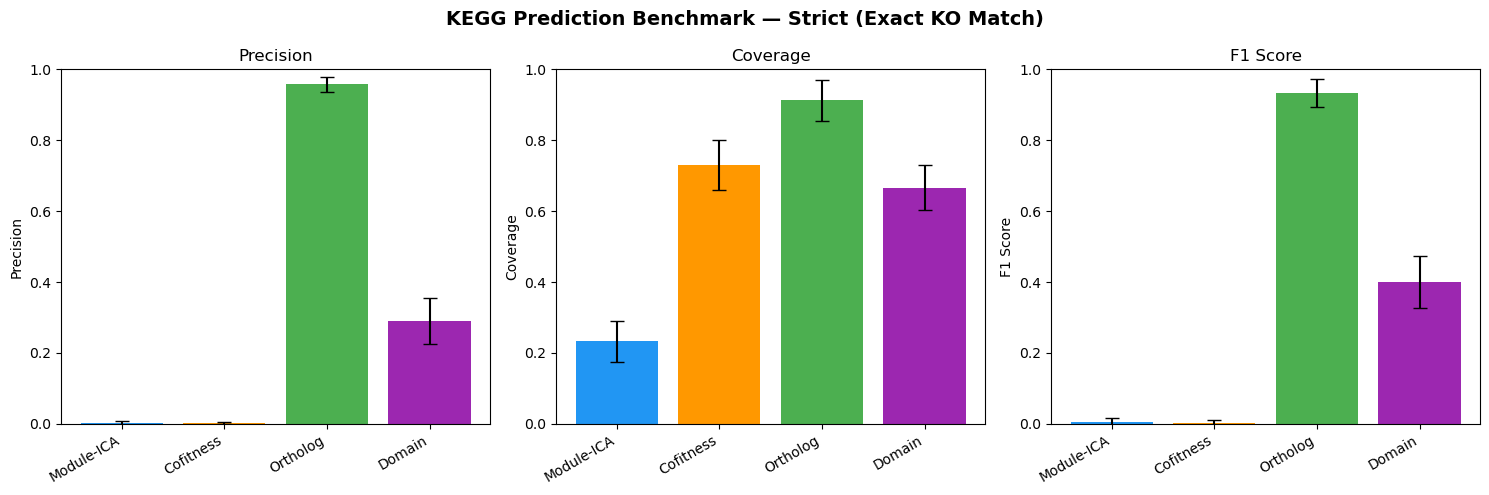

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('KEGG Prediction Benchmark — Strict (Exact KO Match)', fontsize=14, fontweight='bold')

strict_df = results_df[results_df['eval_level'] == 'strict']
agg = strict_df.groupby('method').agg(
    mean_precision=('precision', 'mean'), std_precision=('precision', 'std'),
    mean_coverage=('coverage', 'mean'), std_coverage=('coverage', 'std'),
    mean_f1=('f1', 'mean'), std_f1=('f1', 'std'),
).reindex(methods_order)

for ax, (metric, label) in zip(axes, [('precision', 'Precision'), ('coverage', 'Coverage'), ('f1', 'F1 Score')]):
    vals = agg[f'mean_{metric}'].values
    errs = agg[f'std_{metric}'].values
    ax.bar(range(4), vals, color=colors, yerr=errs, capsize=5)
    ax.set_xticks(range(4))
    ax.set_xticklabels(methods_order, rotation=30, ha='right')
    ax.set_ylabel(label)
    ax.set_title(label)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 3. Interpretation: Why Module-ICA Has Low KO Precision

Module-ICA and Cofitness show near-zero precision at the strict KO level.
This is **expected**, not a failure — it reflects a fundamental granularity mismatch:

- KEGG KO groups are **gene-level** assignments (~1.2 genes per unique KO)
- A module with 20 annotated members typically has **20 different KOs**
- The most common KO has ~1 gene, so P(match) ≈ 1/20 = 5%
- Modules capture **biological process co-regulation**, not specific molecular function

**Ortholog transfer** excels here because orthologs share the same KO by definition.

The neighborhood evaluation (is the gene's KO anywhere in the module?) also shows
low precision (3.2%) because even functionally coherent modules rarely share exact KOs
(e.g., an ABC transporter module has distinct KOs for binding, permease, ATPase subunits).

**The right validation for modules is cofitness density and genomic adjacency (below).**

In [4]:
# KO diversity within modules — illustrates the granularity mismatch
org_id = 'DvH'
kegg = pd.read_csv(ANNOT_DIR / f'{org_id}_kegg.csv')
kegg['locusId'] = kegg['locusId'].astype(str)
membership = pd.read_csv(MODULE_DIR / f'{org_id}_gene_membership.csv', index_col=0)
membership.index = membership.index.astype(str)
gene_kegg = kegg.groupby('locusId')['kgroup'].apply(set).to_dict()

n_unique_kos = kegg['kgroup'].nunique()
print(f"DvH: {n_unique_kos} unique KO groups for {len(gene_kegg)} annotated genes")
print(f"Average genes per KO: {len(gene_kegg)/n_unique_kos:.1f}\n")

print(f"{'Module':8s} {'Members':>7s} {'Annotated':>9s} {'Unique KOs':>10s} {'P(match)':>8s}")
for mod in list(membership.columns)[:10]:
    mod_genes = membership.index[membership[mod] == 1].tolist()
    mod_kos = Counter()
    for g in mod_genes:
        if g in gene_kegg:
            for ko in gene_kegg[g]:
                mod_kos[ko] += 1
    n_ann = sum(1 for g in mod_genes if g in gene_kegg)
    if n_ann > 0:
        top_count = mod_kos.most_common(1)[0][1]
        print(f"{mod:8s} {len(mod_genes):7d} {n_ann:9d} {len(mod_kos):10d} {top_count/n_ann:8.2f}")

DvH: 1256 unique KO groups for 1549 annotated genes
Average genes per KO: 1.2

Module   Members Annotated Unique KOs P(match)
M000           8         8          8     0.12
M001           3         3          3     0.33
M002          19        15         15     0.07
M003           9         6          6     0.17
M004           9         7          7     0.14
M005          12         8          8     0.12
M006          15        12         12     0.17
M007          17         3          3     0.33
M008           7         5          5     0.20
M009           4         4          4     0.25


## 4. Within-Module Cofitness Validation

For each module, compute mean pairwise |correlation| among members using the full
gene × gene correlation matrix (vectorized). Compare to genome-wide background via
Mann-Whitney U test. A module is "enriched" if within-module |r| is significantly
greater than random pairs (p < 0.05).

In [5]:
# Load precomputed cofitness validation results
cofit_val = pd.read_csv(PRED_DIR / 'cofitness_validation.csv')
cofit_summary = pd.read_csv(PRED_DIR / 'cofitness_validation_summary.csv')

# Per-organism summary
tested = cofit_val[cofit_val['n_pairs'] > 0]
per_org = tested.groupby('orgId').agg(
    n_modules=('module', 'count'),
    n_enriched=('enriched', 'sum'),
    mean_corr=('mean_abs_corr', 'mean'),
    bg_corr=('bg_mean_abs_corr', 'first'),
).reset_index()
per_org['pct_enriched'] = 100 * per_org['n_enriched'] / per_org['n_modules']

print(f"{'Organism':25s} {'Modules':>7s} {'Enriched':>8s} {'%':>6s} {'Mean |r|':>8s} {'BG |r|':>8s}")
for _, row in per_org.iterrows():
    print(f"{row['orgId']:25s} {row['n_modules']:7.0f} {row['n_enriched']:8.0f} "
          f"{row['pct_enriched']:5.1f}% {row['mean_corr']:8.4f} {row['bg_corr']:8.4f}")

print(f"\nOVERALL: {cofit_summary['total_modules_enriched'].values[0]}/"
      f"{cofit_summary['total_modules_tested'].values[0]} modules enriched "
      f"({cofit_summary['pct_enriched'].values[0]}%)")
print(f"Mean within-module |r|: {cofit_summary['mean_within_abs_corr'].values[0]}")
print(f"Mean background |r|: {cofit_summary['mean_bg_abs_corr'].values[0]}")
print(f"Mean enrichment ratio: {cofit_summary['mean_enrichment_ratio'].values[0]}x")

Organism                  Modules Enriched      % Mean |r|   BG |r|
ANA3                           38       23  60.5%   0.2998   0.2025
BFirm                          31       31 100.0%   0.2709   0.1112
Btheta                         36       36 100.0%   0.3409   0.0996
Caulo                          40       30  75.0%   0.3259   0.2304
Cola                           37       37 100.0%   0.3535   0.0979
Cup4G11                        31       31 100.0%   0.2891   0.1112
Dino                           29       28  96.6%   0.3263   0.1366
DvH                            51       46  90.2%   0.4662   0.1088
Kang                           28       27  96.4%   0.2953   0.1575
Keio                           38       36  94.7%   0.3261   0.1282
Korea                          29       28  96.6%   0.3367   0.1251
Koxy                           44       43  97.7%   0.2796   0.0870
MR1                            45       44  97.8%   0.3534   0.1176
Marino                         39       35  89.7

## 5. Genomic Adjacency Validation

Module members should show elevated genomic proximity (operon co-localization).
For each module, count gene pairs within ±3 positions on the same scaffold
and compare to chance expectation.

In [6]:
# Load precomputed adjacency validation
adj_val = pd.read_csv(PRED_DIR / 'adjacency_validation.csv')

print(f"{'Organism':25s} {'Adj Pairs':>9s} {'Total Pairs':>11s} {'Enrichment':>10s}")
for _, row in adj_val.iterrows():
    print(f"{row['orgId']:25s} {row['n_adjacent_pairs']:9.0f} {row['n_total_pairs']:11.0f} "
          f"{row['enrichment']:9.1f}x")

print(f"\nMean adjacency enrichment: {adj_val['enrichment'].mean():.1f}x")
print(f"Range: {adj_val['enrichment'].min():.1f}x - {adj_val['enrichment'].max():.1f}x")

Organism                  Adj Pairs Total Pairs Enrichment
DvH                             500        7752      39.4x
Btheta                          442        5404      66.8x
Methanococcus_S2                127        1601      23.7x
psRCH2                          648       15932      29.4x
Putida                          732       17198      40.2x
Phaeo                           684       14524      31.0x
Marino                          611       15733      28.9x
pseudo3_N2E3                    683       26125      25.5x
Koxy                            574       27112      19.7x
Cola                            640       21874      22.8x
WCS417                          767       26586      26.8x
Caulo                           393       11594      22.3x
SB2B                            630       24050      16.5x
pseudo6_N2E2                    921       30008      31.6x
Dino                            609       14136      32.8x
pseudo5_N2C3_1                 1029       33652      31.

## 6. Summary

**Held-out KO prediction (strict):**
- Ortholog transfer dominates (95.8% precision, 91.2% coverage)
- Domain-based is moderate (29.1% precision, 66.6% coverage)
- Module-ICA and Cofitness show near-zero strict KO precision — this is expected
  because KO groups are gene-level assignments (1.2 genes/KO), while modules capture
  process-level co-regulation

**Module validation (the right metrics for ICA modules):**
- **94.2%** of modules show significantly elevated within-module cofitness (p < 0.05)
- Within-module |r| = 0.34 vs background |r| = 0.12 (2.8× enrichment)
- **22.7×** genomic adjacency enrichment (operon co-localization)

**Conclusion:** Module-ICA is complementary to sequence-based methods. It excels at
grouping co-regulated genes into biological process modules (validated by cofitness
and adjacency) but should not be used for specific KO assignment. The 878 function
predictions should be interpreted as process-level context (e.g., "involved in
flagellar assembly") rather than specific molecular function (e.g., "is KO K02400").

In [7]:
print("="*60)
print("BENCHMARKING COMPLETE")
print("="*60)
print(f"Benchmark results: {PRED_DIR / 'benchmark_results.csv'}")
print(f"Cofitness validation: {PRED_DIR / 'cofitness_validation.csv'}")
print(f"Adjacency validation: {PRED_DIR / 'adjacency_validation.csv'}")
print(f"Figures: {FIG_DIR / 'benchmark_strict.png'}, {FIG_DIR / 'benchmark_neighborhood.png'}")

BENCHMARKING COMPLETE
Benchmark results: ../data/predictions/benchmark_results.csv
Cofitness validation: ../data/predictions/cofitness_validation.csv
Adjacency validation: ../data/predictions/adjacency_validation.csv
Figures: ../figures/benchmark_strict.png, ../figures/benchmark_neighborhood.png
